In [365]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
np.set_printoptions(precision=2)

# UKF & Power growth model

Minule jsme studovali nasazení rozšířeného Kalmanova filtru - EKF - na PGM model. Nyní nasadíme na tentýž model jiný nelinární filtr - UKF. Připomeňme, že PGM model má tvar

$$
\begin{alignat}{2}
y_t &= k + \mu_t + \varepsilon_t, \qquad &\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \\
\mu_t &= \mu_{t-1}^{1+\nu_{t-1}} + \xi_t, \qquad &\xi_t \sim \mathcal{N}(0, \sigma_{\xi}^2), \\
\nu_t &= \rho\nu_{t-1} + \zeta_t, \qquad &\zeta_t \sim \mathcal{N}(0, \sigma_{\zeta}^2),
\end{alignat}
$$

kde $\rho\in[0,1]$ je "discounting" faktor a $k$ je drift. Obě tyto proměnné buď známe, nebo je musíme vhodně odhadnout.

Modely tohoto typu jsou populární např. v epidemiologii, kde se uvažuje namísto mocniny přímo exponenciální funkce (a odtud je další cesta k "magickému" reprodukčnímu číslu). Související proces bude logicky velmi citlivý na kombinace hodnot $\nu_t$ a $\mu_t$. Stačí, aby se chviličku udržela nevhodná kombinace a proces exploduje.

Zkusíme si nasimulovat nějakou pěknou časovou řadu. Pro simulaci si nastavíme rozumnou hodnotu $k$, aby nám později filtrace neskončila odmocňováním záporných čísel.

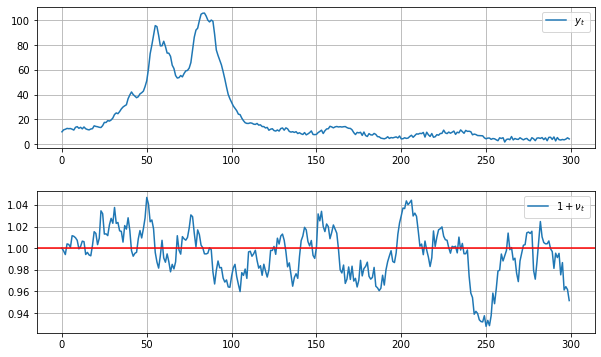

In [377]:
ndat = 300
npred = 50

sigma_epsilon = 1.
sigma_xi = .1
sigma_zeta = .01
rho = 0.9
k = 2
mu = np.zeros(ndat); mu[0] = 10.
nu = np.zeros(ndat)
y = np.zeros(ndat); y[0] = 10.

for t in range(1, ndat):
    nu[t] = rho * nu[t-1] + norm.rvs(scale=sigma_zeta)
    mu[t] = mu[t-1]**(1+nu[t-1]) + norm.rvs(scale=sigma_xi)
    y[t] = k + mu[t] + norm.rvs(scale=sigma_epsilon)
    if mu[t] < 0:
        break
    
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(y, label=r'$y_t$')
plt.legend()
plt.subplot(2,1,2)
plt.plot(1+nu, label=r'$1+\nu_t$')
plt.axhline(1, color='red')
plt.legend()
plt.show()

## Algoritmus UKF

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Inicializace sigma-bodů
$$
\begin{align}
\hat{x}_{t-1}^{(i)} &= \hat{x}_{t-1}^+ + \tilde{x}^{(i)}, &i=1,\ldots,2n,\\
\tilde{x}^{(i)} &= \left( \sqrt{nP_{t-1}^+} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{nP_{t-1}^+} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{(i)} &= f_t\left(\hat{x}_{t-1}^{(i)}, u_t\right),\\
\hat{x}_t^- &= \frac{1}{2n} \sum_{i=1}^{2n} \hat{x}_t^{(i)},\\
P_t^- &= \frac{1}{2n} \sum_{i=1}^{2n} 
\left(\hat{x}_t^{(i)} - \hat{x}_t^-\right)
\left(\hat{x}_t^{(i)} - \hat{x}_t^-\right)^\intercal
+ Q_t
\end{align}
$$

    - Volitelná reinicializace sigma-bodů pro korekci
$$
\begin{align}
\hat{x}_{t}^{(i)} &= \hat{x}_{t}^- + \tilde{x}^{(i)}, &i=1,\ldots,2n,\\
\tilde{x}^{(i)} &= \left( \sqrt{nP_{t}^-} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{nP_{t}^-} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

    - Korekce (datový update) stavů pozorováním
$$
\begin{aligned}
\hat{y}_t^{(i)} &= h_t\left(\hat{x}_t^{(i)}\right) \\
\hat{y}_t &= \frac{1}{2n} \sum_{i=1}^{2n} \hat{y}_t^{(i)}\\
P_y &= \frac{1}{2n}\sum_{i=1}^{2n} 
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)^\intercal + R_t \\
P_{xy} &= \frac{1}{2n}\sum_{i=1}^{2n} 
\left( \hat{x}_t^{(i)} - \hat{x}_t^- \right)
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)^\intercal \\
\ & \\
K_t &= P_{xy}P_y^{-1} \\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t\left[y_t - \hat{y}_t\right]\\
P_t^{+} &= P_t^- - K_t P_y K_t^\intercal.
\end{aligned}
$$


### Připomeňme náš model:

$$
\begin{alignat}{2}
y_t &= k + \mu_t + \varepsilon_t, \qquad &\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \\
\mu_t &= \mu_{t-1}^{1+\nu_{t-1}} + \xi_t, \qquad &\xi_t \sim \mathcal{N}(0, \sigma_{\xi}^2), \\
\nu_t &= \rho\nu_{t-1} + \zeta_t, \qquad &\zeta_t \sim \mathcal{N}(0, \sigma_{\zeta}^2),
\end{alignat}
$$

kde $x_t = [\mu_t, \nu_t]^\intercal$. Stavová rovnice je, narozdíl od rovnice měření, nelineární. V UKF nelinearizujeme. Podívejme se tedy na vývoj stavů v podobě vektoru:

$$
\begin{aligned}
\begin{bmatrix} \mu_t \\ \nu_t \end{bmatrix}
= 
\begin{bmatrix} \mu_{t-1}^{1+\nu_{t-1}} \\ \rho\nu_{t-1} \end{bmatrix}
+ \begin{bmatrix} \xi_t \\ \zeta_t \end{bmatrix}
\end{aligned}
$$

Budeme muset upravit třídu `KF` (příp. `EKF` z minula) tak, abychom mohli použít sigma body. Stejně jako minule nemusíme měnit korekční krok, neboť rovnice měření je lineární.

Změny jsou vyznačeny:

In [378]:
class UKF():
    def __init__(self, F, B, H, R, Q):
        self.F = F                          ### Dtto jako A u linearniho KF
        self.B = B
        self.H = H
        self.R = R
        self.Q = Q
        self.P = np.eye(self.Q.shape[0]) * 10.
        self.x = np.array([1., 1.])
        self.log_x = []
        self.rho = 0.9                         ### ZDE jsme přidali rho
        self.n = self.x.size
        
    def UT(self):
        nP = self.n * self.P
        sqrt_nP = np.linalg.cholesky(nP).T
        x_i = []
        for i in range(self.n):
            x_i.append(self.x - sqrt_nP[i])
            x_i.append(self.x + sqrt_nP[i])
        return x_i
    
    def predict(self, u=None):               ### ZDE jsme změnili výpočet predikovaných veličin
        x_i = self.UT()
        
        # Update of x
        xminus = np.zeros_like(self.x)
        x_i_new_list = []
        for i in range(2*self.n):
            mu, nu = x_i[i][0], x_i[i][1]
            x_i_new = np.array([mu**(1.+nu), self.rho * nu])
            x_i_new_list.append(x_i_new.copy())
            xminus += x_i_new
        xminus /= (2 * self.n)
            
        # Update of P
        Pminus = np.zeros_like(self.P)
        for i in range(2*self.n):
            x_i_new = x_i_new_list[i]
            Pminus += np.outer(x_i_new - xminus, x_i_new - xminus)
        Pminus /= (2 * self.n)
        Pminus += self.Q

        self.x = xminus
        self.P = Pminus
    
    def correct(self, yt, k=0):
        HPHT = self.H.dot(self.P).dot(self.H.T)
        zavorka_inv = np.linalg.inv(HPHT + self.R)
        K = self.P.dot(self.H.T).dot(zavorka_inv)
        innovation = yt - (self.H.dot(self.x) + k)
        xplus = self.x + K.dot(innovation)
        zavorka = np.eye(K.shape[0]) - K.dot(self.H)
        KRKT = K.dot(self.R).dot(K.T)
        Pplus = zavorka.dot(self.P).dot(zavorka.T) + KRKT
        self.x = xplus
        self.P = Pplus
    
    def log(self):
        self.log_x.append(self.x)

In [379]:
Q = np.diag([sigma_xi**2, sigma_zeta**2])
H = np.array([[1, 0]])
R = np.atleast_2d(sigma_epsilon**2)

ukf = UKF(F=None, B=2., H=H, R=R, Q=Q)
ukf.P[1,1] = 1.
ukf.UT()

for t in range(ndat):
    ukf.predict()
    ukf.correct(np.atleast_1d(y[t]), k=k)
    ukf.log()
    
log_x = np.array(ukf.log_x).T

### Predikce

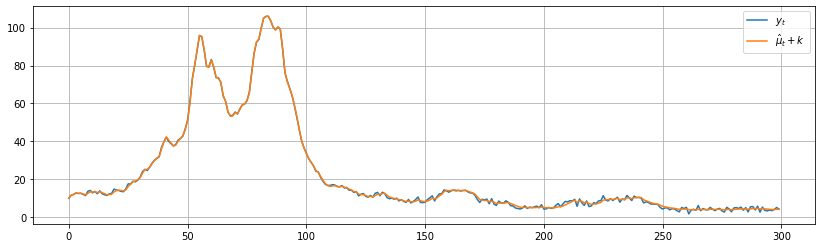

In [380]:
plt.figure(figsize=(14,4))
plt.plot(y, label=r'$y_t$')
plt.plot(k+log_x[0].T, label=r'$\hat{\mu}_t + k$')
plt.legend()

### Odhady stavových veličin

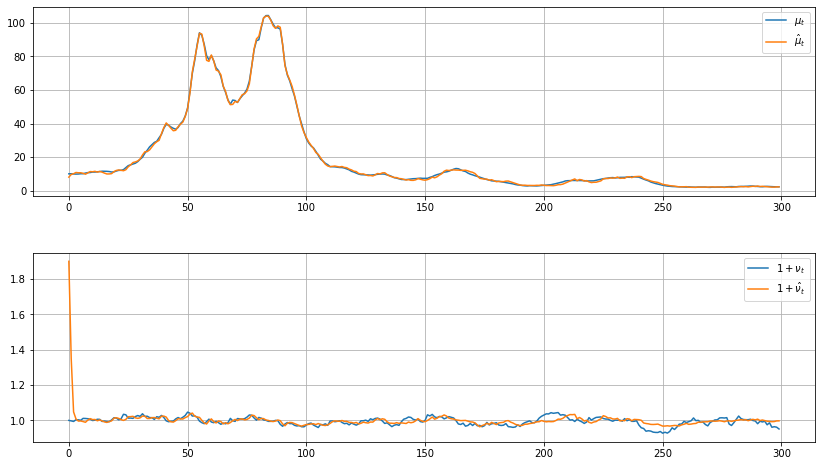

In [381]:
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(mu, label=r'${\mu}_t$')
plt.plot(log_x[0].T, label=r'$\hat{\mu}_t$')
plt.legend()
plt.subplot(2,1,2)
plt.plot(1+nu, label=r'$1+\nu_t$')
plt.plot(1+log_x[1].T, label=r'$1+\hat{\nu}_t$')
plt.legend()

## Poznámka závěrem

Jedna z komplikací, na něž lze v průběhu ladění filtru (a nejen UKF) narazit, spočívá ve stavové rovnici pro $\mu_t$:

$$
\mu_t = \mu_{t-1}^{1-\nu_t} + \xi_t.
$$

Pokud nenaladíme vhodně kovariance okolo přípustných hodnot $\nu_t$ a neošetříme možné hodnoty $\mu_{t-1}$ **a to včetně sigma bodů**, můžeme se dostat do situace, kdy $\hat\mu_{t-1}^{(i)}<0$ a $\hat{\nu}_{t-1}<1$, tj. odmocňujeme záporné číslo. A s tím nám filtr fungovat nebude...